# Прогнозирование объема кредитов МСП с помощью ARIMA

In [99]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import itertools
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
import statsmodels.api as sm
from openpyxl import load_workbook 

from parser.gdp import get_gdp_dataframe
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_loans_volume_msp_df

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit

from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer

In [2]:
warnings.filterwarnings("ignore")

Вспомогательные функции:

In [3]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    
def mape( actual , pred ): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))* 100

## Подготовка датафрейма 

In [4]:
df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024, spikes_remove=False))
df

,date,month_n,year,Отчетный период,msp_loans_volume
0,2019-01-01,1,2019,Январь 2019 г.,452992.0
1,2019-02-01,2,2019,Февраль 2019 г.,482114.0
2,2019-03-01,3,2019,Март 2019 г.,604402.0
3,2019-04-01,4,2019,Апрель 2019 г.,686986.0
4,2019-05-01,5,2019,Май 2019 г.,585284.0
...,...,...,...,...,...
59,2023-12-01,12,2023,Декабрь 2023 г.,1854476.0
60,2024-01-01,1,2024,Январь 2024 г.,935130.0
61,2024-02-01,2,2024,Февраль 2024 г.,1216737.0
62,2024-03-01,3,2024,Март 2024 г.,1524903.0


In [5]:
df_spike_remove = transform_df_to_format(get_loans_volume_msp_df(2019, 2024, spikes_remove=True))
df_spike_remove

,date,month_n,year,Отчетный период,msp_loans_volume
0,2019-01-01,1,2019,Январь 2019 г.,4.028862e+05
1,2019-02-01,2,2019,Февраль 2019 г.,4.208281e+05
2,2019-03-01,3,2019,Март 2019 г.,7.157937e+05
3,2019-04-01,4,2019,Апрель 2019 г.,6.368802e+05
4,2019-05-01,5,2019,Май 2019 г.,5.239981e+05
...,...,...,...,...,...
59,2023-12-01,12,2023,Декабрь 2023 г.,1.437707e+06
60,2024-01-01,1,2024,Январь 2024 г.,1.221420e+06
61,2024-02-01,2,2024,Февраль 2024 г.,1.155451e+06
62,2024-03-01,3,2024,Март 2024 г.,1.636295e+06


In [6]:
# Для постороения прогноза по скорректированным данным запустить данную строчку
# df = df_spike_remove

In [7]:
# Извлекаем год из столбца "Отчетный период"
df['date'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)

# Формируем новый столбец "Дата" в формате YYYY-MM
df['date'] = df['date'].astype(str) + '-' + df['month_n'].astype(str)
df['date'] = pd.to_datetime(df['date'])

# Удаляем временные столбцы
df = df[['date', 'msp_loans_volume']]
df = df.reset_index()
df = df.drop('index', axis = 1)
df

,date,msp_loans_volume
0,2019-01-01,452992.0
1,2019-02-01,482114.0
2,2019-03-01,604402.0
3,2019-04-01,686986.0
4,2019-05-01,585284.0
...,...,...
59,2023-12-01,1854476.0
60,2024-01-01,935130.0
61,2024-02-01,1216737.0
62,2024-03-01,1524903.0


Посмотрим на данные:

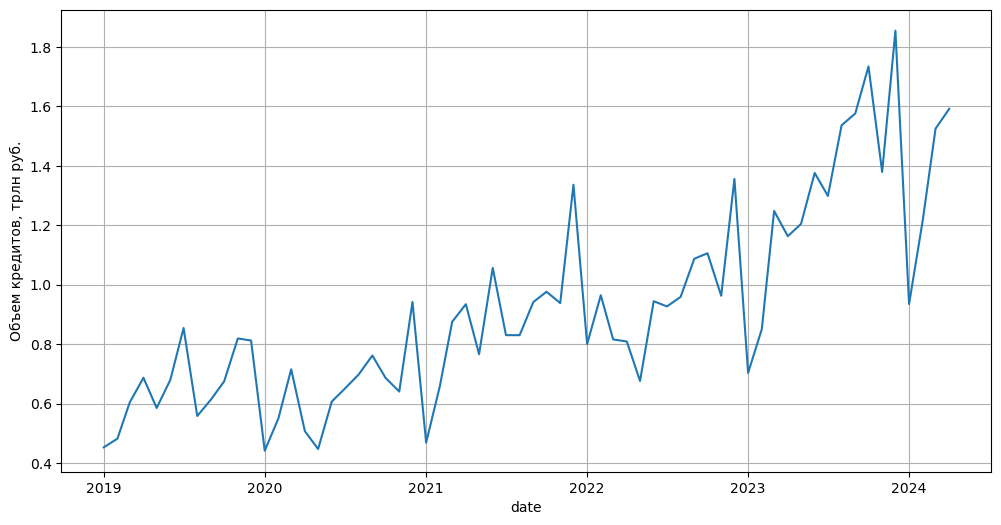

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

Посмотрим на декомпозицию

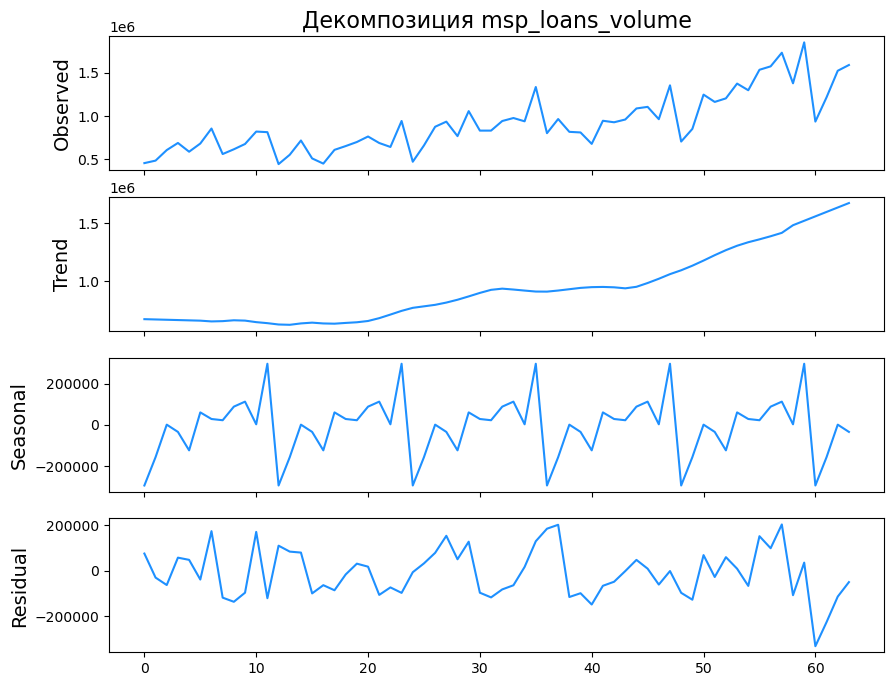

In [9]:
# Декомпозиция
decomp = seasonal_decompose(df['msp_loans_volume'], period=12, model='additive', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,8))
res = decomp

ax[0].set_title('Декомпозиция {}'.format('msp_loans_volume'), fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

Разделим данные на train и test выборки:

In [10]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

train_size =  54
test_size =  10


In [11]:
split_date = df['date'].iloc[train_size]
split_date

Timestamp('2023-07-01 00:00:00')

In [12]:
# разделение данных на тестовые и тренировочные
train = df[df['date']<split_date]
test = df[df['date']>=split_date]

In [13]:
train # тренировочная выборка

,date,msp_loans_volume
0,2019-01-01,452992.0
1,2019-02-01,482114.0
2,2019-03-01,604402.0
3,2019-04-01,686986.0
4,2019-05-01,585284.0
5,2019-06-01,680248.0
6,2019-07-01,854372.0
7,2019-08-01,558370.0
8,2019-09-01,613515.0
9,2019-10-01,674912.0


In [14]:
test # тестовая выборка

,date,msp_loans_volume
54,2023-07-01,1298757.0
55,2023-08-01,1536289.0
56,2023-09-01,1576041.0
57,2023-10-01,1734270.0
58,2023-11-01,1379337.0
59,2023-12-01,1854476.0
60,2024-01-01,935130.0
61,2024-02-01,1216737.0
62,2024-03-01,1524903.0
63,2024-04-01,1591673.0


In [15]:
# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

## Стационарность

(0.6264980607479527, 0.9882508726416358, 11, 42, {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}, 1134.227757090145)


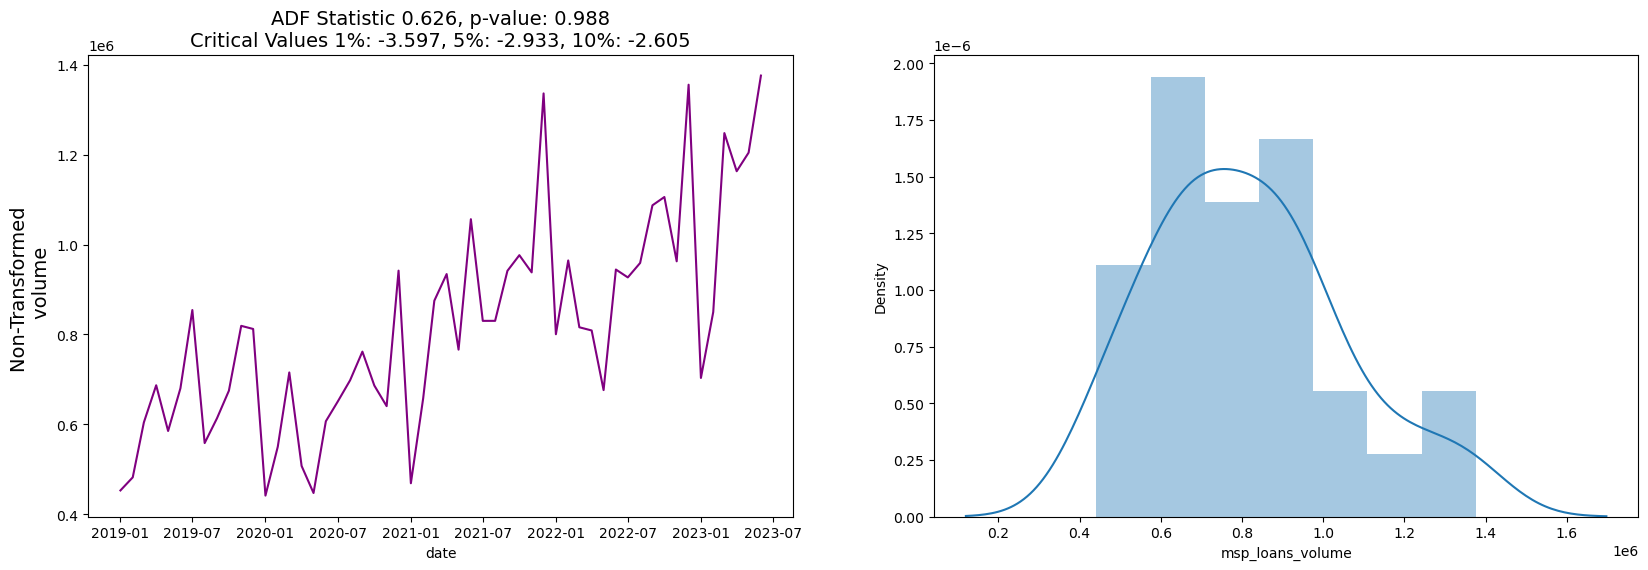

In [16]:
print(adfuller(train['msp_loans_volume'])) # Данные не стационарны

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(train['msp_loans_volume'], 'Non-Transformed \n volume', ax[0])
sns.distplot(train['msp_loans_volume'], ax=ax[1])

plt.show()

Трансформируем данные:

In [17]:
transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
adfuller(trn_transform)# Данные не стационарны

(0.3572303275727101,
 0.979823093458222,
 11,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 -7.889576035577306)

In [18]:
transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

adfuller(trn_transform)# Данные стационарны!

(-5.643975015004436,
 1.0213230695113866e-06,
 4,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 -10.219730822682607)

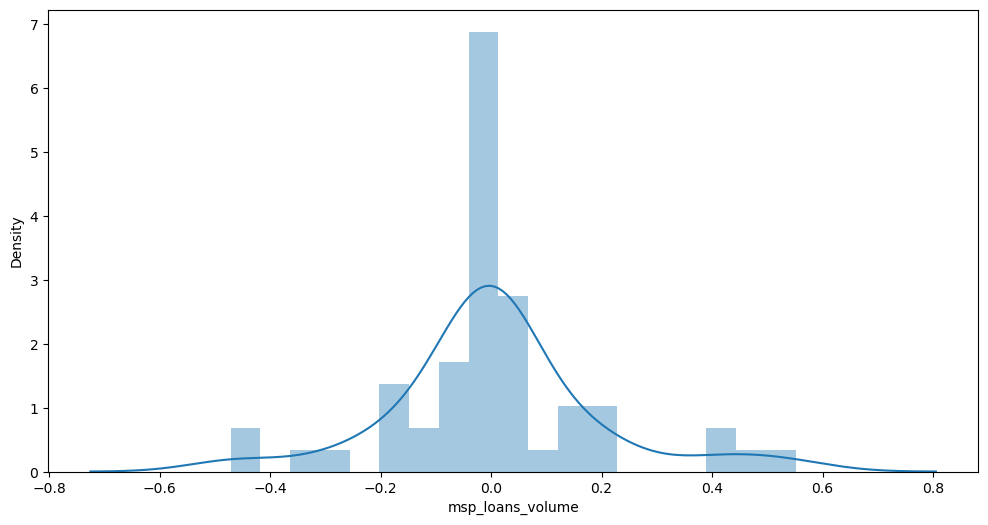

In [19]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(trn_transform)
plt.show()

# Обучение модели

In [20]:
model = ARIMA(trn_transform, order=(1,1,1))
model_fit = model.fit()
model_fit.aic

-17.488149574891494

In [21]:
model_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       msp_loans_volume   No. Observations:                   54
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  11.744
Date:                Mon, 01 Jul 2024   AIC                            -17.488
Time:                        10:02:39   BIC                            -11.577
Sample:                    01-01-2019   HQIC                           -15.215
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1074      0.198     -0.542      0.588      -0.496       0.281
ma.L1         -0.9985      4.054     -0.246      0.805      -8.945       6.948
sigma2         0.0348      0.141      0.247      0.805      -0.242       0.311
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.49
Prob(Q):                              0.83   Prob(JB):                         0.01
Heteroskedasticity (H):               2.60   Skew:                             0.30
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

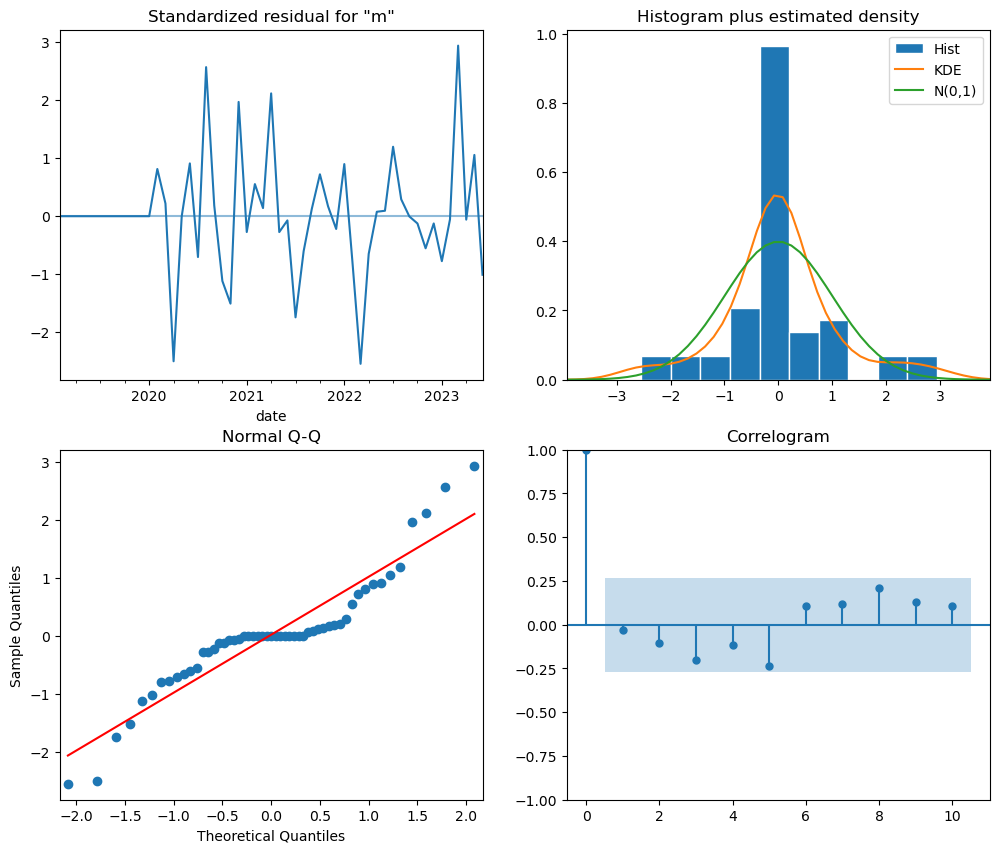

In [22]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

# Прогноз

In [23]:
pred = model_fit.get_prediction(start=split_date.strftime('%Y-%m-%d'), end='2025-03-01', dynamic=False)
# The significance level for the confidence interval.
# The default alpha = .05 returns a 95% confidence interval.
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean

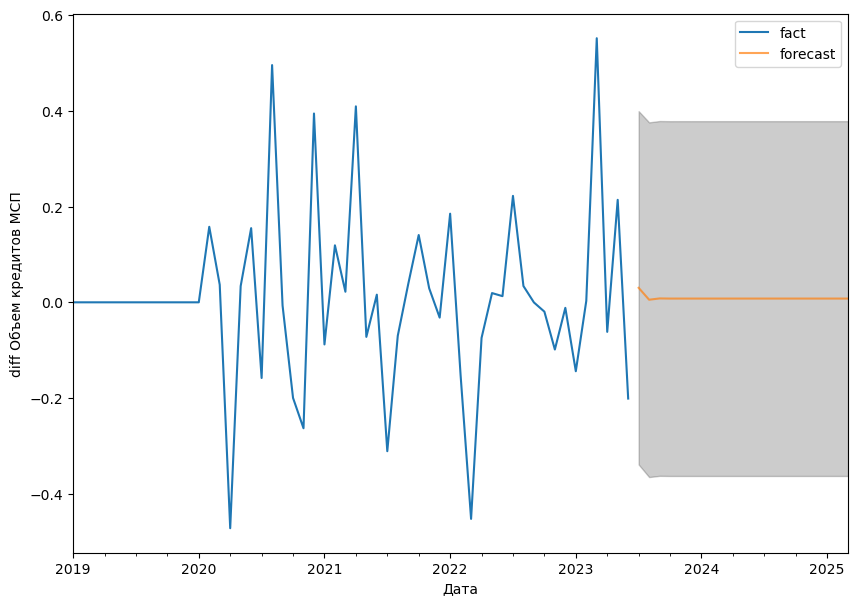

In [24]:
ax = trn_transform.plot(label='fact', figsize=(10, 7))
#ax.set_ylim([-1.5, 1.5])
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Дата')
ax.set_ylabel('diff Объем кредитов МСП')
plt.legend()
plt.show()

In [25]:
res = transformer_2.inverse_transform(vol_diff_pred)
res = transformer_1.inverse_transform(res)
res

2023-07-01    1.392028e+06
2023-08-01    1.448092e+06
2023-09-01    1.655120e+06
2023-10-01    1.696401e+06
2023-11-01    1.488582e+06
2023-12-01    2.112601e+06
2024-01-01    1.104553e+06
2024-02-01    1.345536e+06
2024-03-01    1.991174e+06
2024-04-01    1.870346e+06
2024-05-01    1.952037e+06
2024-06-01    2.247478e+06
2024-07-01    2.291491e+06
2024-08-01    2.402538e+06
2024-09-01    2.767626e+06
2024-10-01    2.858975e+06
2024-11-01    2.528472e+06
2024-12-01    3.616651e+06
2025-01-01    1.905809e+06
2025-02-01    2.339873e+06
2025-03-01    3.489874e+06
Freq: MS, Name: predicted_mean, dtype: float64

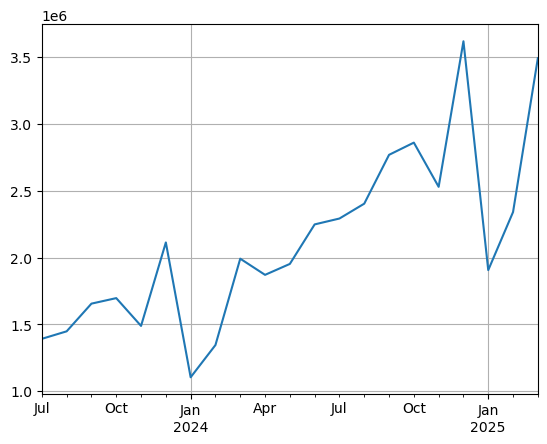

In [26]:
res.plot()
plt.grid(True)

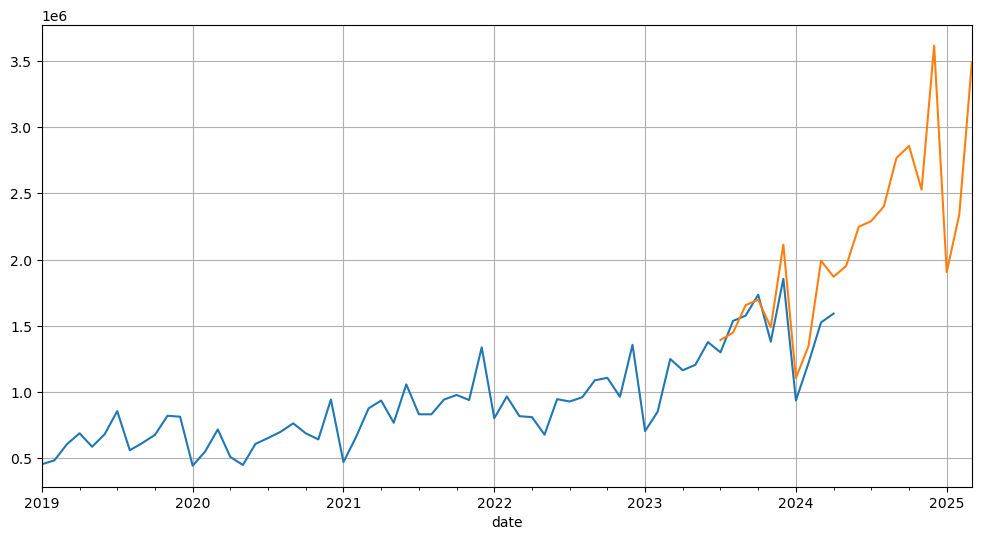

In [27]:
my_df = df.copy()
my_df = my_df[['date','msp_loans_volume']]
my_df['msp_loans_volume'] = my_df['msp_loans_volume'].astype(float)

my_df.set_index(keys='date', drop=True, inplace=True)
my_df = my_df.squeeze(axis=1)

plt.figure(figsize=(12, 6))
my_df.plot()
res.plot()
plt.grid(True)
plt.show()

In [28]:
test_pred = res[0:test_size]
mape(tst_ser.values, test_pred.values)

11.875109743077266

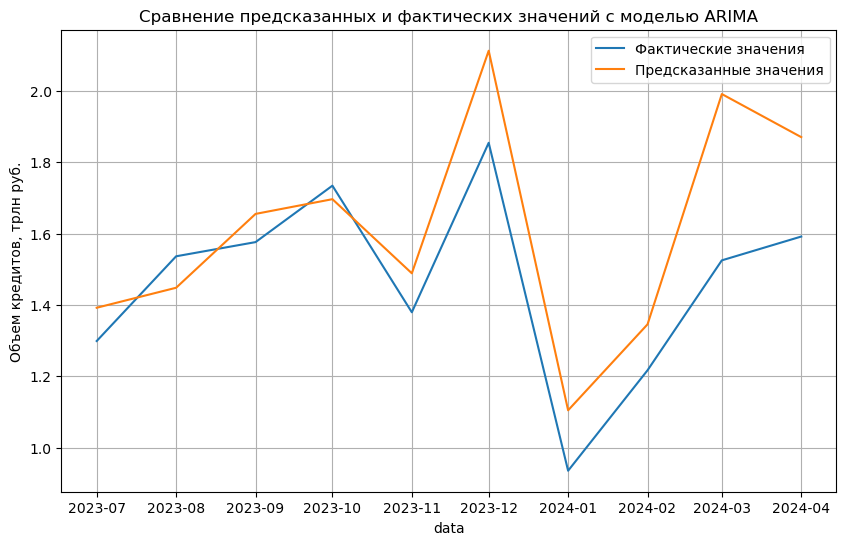

In [29]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()

## Изменим разделение на train и test

Модель обучалась на тренировочной выборке, составлявшей примерно 85% данных. Уменьшим тренировочную выборку и соответственно увеличим тестовую. Рассмотрим несколько вариантов.

Вариант 1 (80 к 20):

In [30]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

train_size =  51
test_size =  13


In [31]:
split_date = df['date'].iloc[train_size]
split_date

Timestamp('2023-04-01 00:00:00')

In [32]:
# разделение данных на тестовые и тренировочные

train = df[df['date']<split_date]
test = df[df['date']>=split_date]

In [33]:
# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

In [34]:
# Мы уже знаем, что исходные данные не стационарны, поэтому сразу применим к ним операции трансформации

transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
print(adfuller(trn_transform))# Данные не стационарны

transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

print(adfuller(trn_transform))# Данные стационарны!

(-0.018981949340274543, 0.9569338561481834, 11, 39, {'1%': -3.610399601308181, '5%': -2.939108945868946, '10%': -2.6080629651545038}, -5.5433088082984625)
(-5.48531548403761, 2.2367837375185465e-06, 4, 46, {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}, -8.40050704542378)


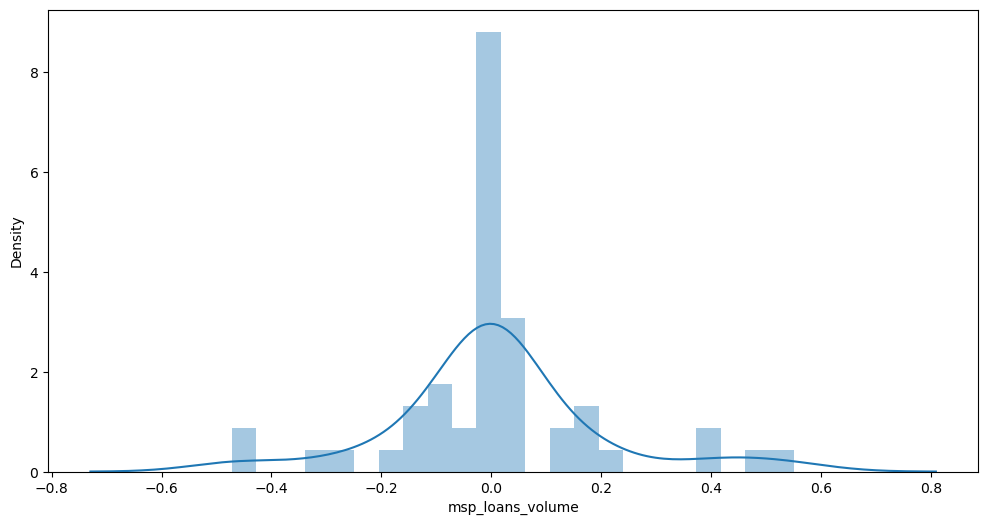

In [35]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(trn_transform)
plt.show()

In [36]:
# обучение модели

model = ARIMA(trn_transform, order=(1,1,1))
model_fit = model.fit()
model_fit.aic

-15.195644628897885

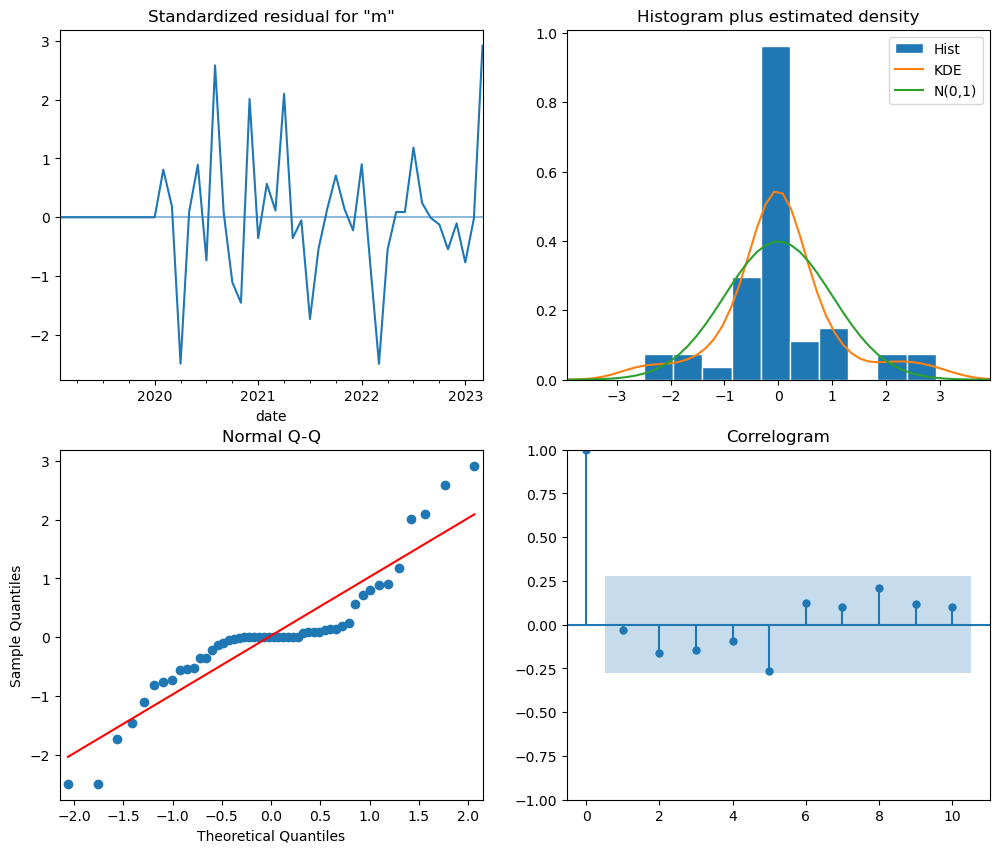

In [37]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

In [38]:
# прогноз

pred = model_fit.get_prediction(start=split_date.strftime('%Y-%m-%d'), end='2025-03-01', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean

res = transformer_2.inverse_transform(vol_diff_pred)
res = transformer_1.inverse_transform(res)
res

2023-04-01    1.202237e+06
2023-05-01    1.015898e+06
2023-06-01    1.430200e+06
2023-07-01    1.415224e+06
2023-08-01    1.476258e+06
2023-09-01    1.687433e+06
2023-10-01    1.730139e+06
2023-11-01    1.518682e+06
2023-12-01    2.156030e+06
2024-01-01    1.127631e+06
2024-02-01    1.374103e+06
2024-03-01    2.034118e+06
2024-04-01    1.975419e+06
2024-05-01    1.682931e+06
2024-06-01    2.388691e+06
2024-07-01    2.383062e+06
2024-08-01    2.506221e+06
2024-09-01    2.888222e+06
2024-10-01    2.985602e+06
2024-11-01    2.642195e+06
2024-12-01    3.781811e+06
2025-01-01    1.994155e+06
2025-02-01    2.449955e+06
2025-03-01    3.656470e+06
Freq: MS, Name: predicted_mean, dtype: float64

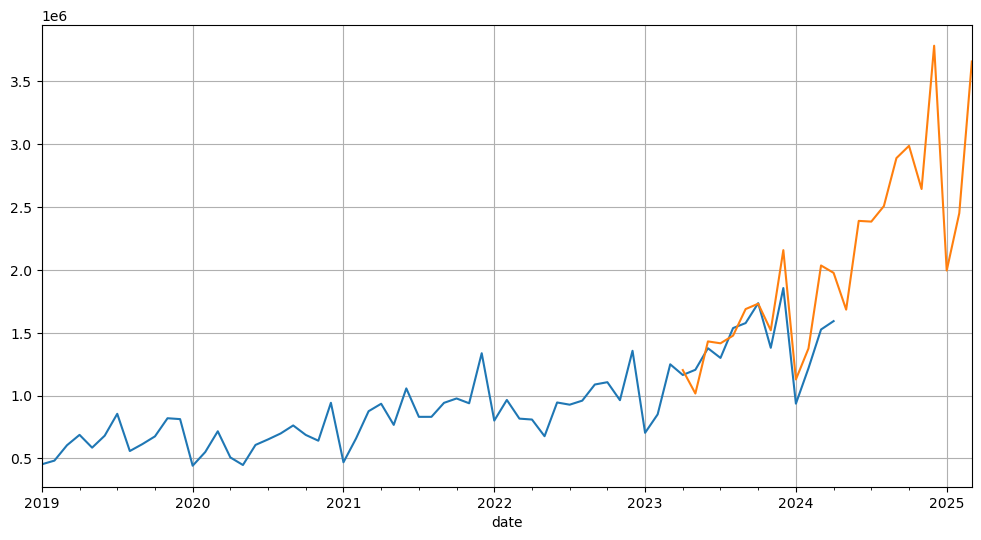

In [39]:
my_df = df.copy()
my_df = my_df[['date','msp_loans_volume']]
my_df['msp_loans_volume'] = my_df['msp_loans_volume'].astype(float)

my_df.set_index(keys='date', drop=True, inplace=True)
my_df = my_df.squeeze(axis=1)

plt.figure(figsize=(12, 6))
my_df.plot()
res.plot()
plt.grid(True)
plt.show()

In [40]:
test_pred = res[0:test_size]
mape(tst_ser.values, test_pred.values) 

12.347560524945365

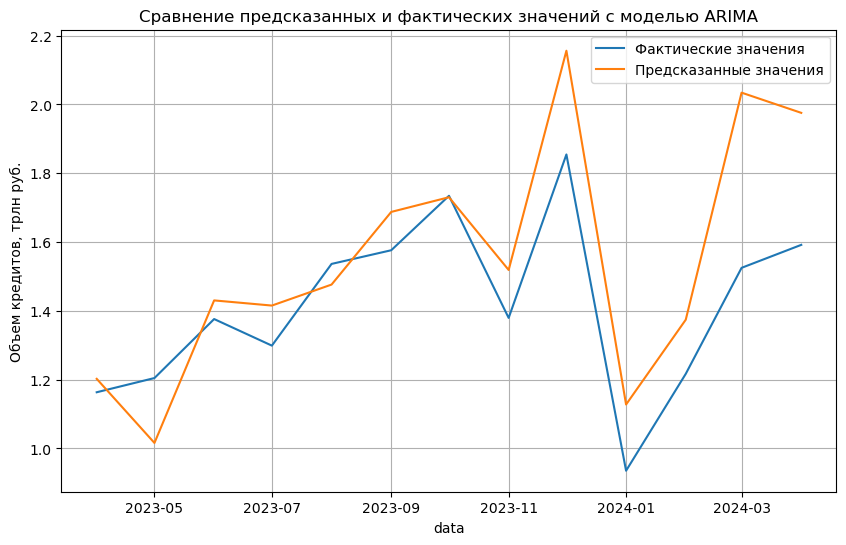

In [41]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()

Вариант 2 (75 к 25):

In [42]:
train_size = int(0.75 * len(df))
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

train_size =  48
test_size =  16


In [43]:
split_date = df['date'].iloc[train_size]
split_date

Timestamp('2023-01-01 00:00:00')

In [44]:
# разделение данных на тестовые и тренировочные

train = df[df['date']<split_date]
test = df[df['date']>=split_date]

In [45]:
# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

In [46]:
# Мы уже знаем, что исходные данные не стационарны, поэтому сразу применим к ним операции трансформации

transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
print(adfuller(trn_transform))# Данные не стационарны

transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

print(adfuller(trn_transform))# Данные стационарны!

(-1.39822180493097, 0.5831283100636269, 2, 45, {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}, -2.287988144666471)
(-5.4610779376305505, 2.517850239058942e-06, 4, 43, {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}, -13.116078248273453)


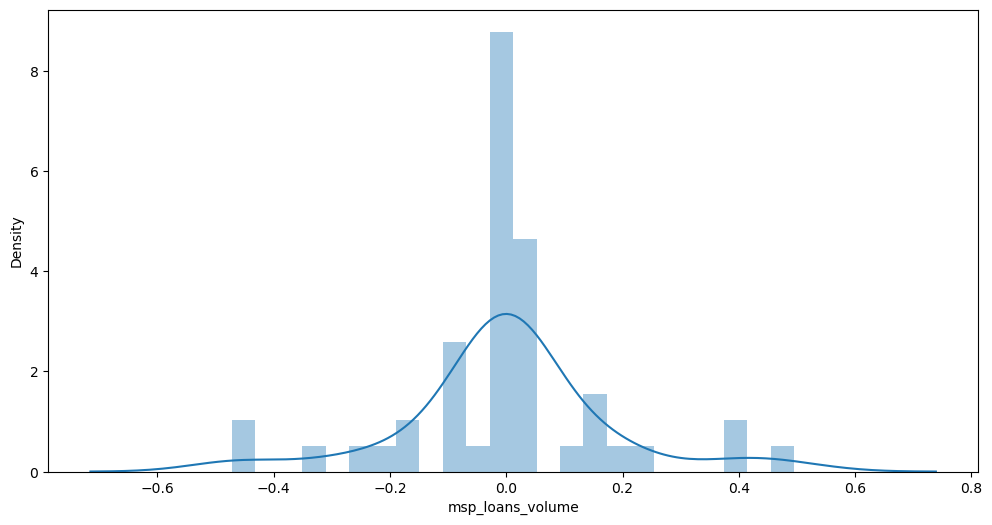

In [47]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(trn_transform)
plt.show()

In [48]:
# обучение модели

model = ARIMA(trn_transform, order=(1,1,1))
model_fit = model.fit()
model_fit.aic

-20.27442586243276

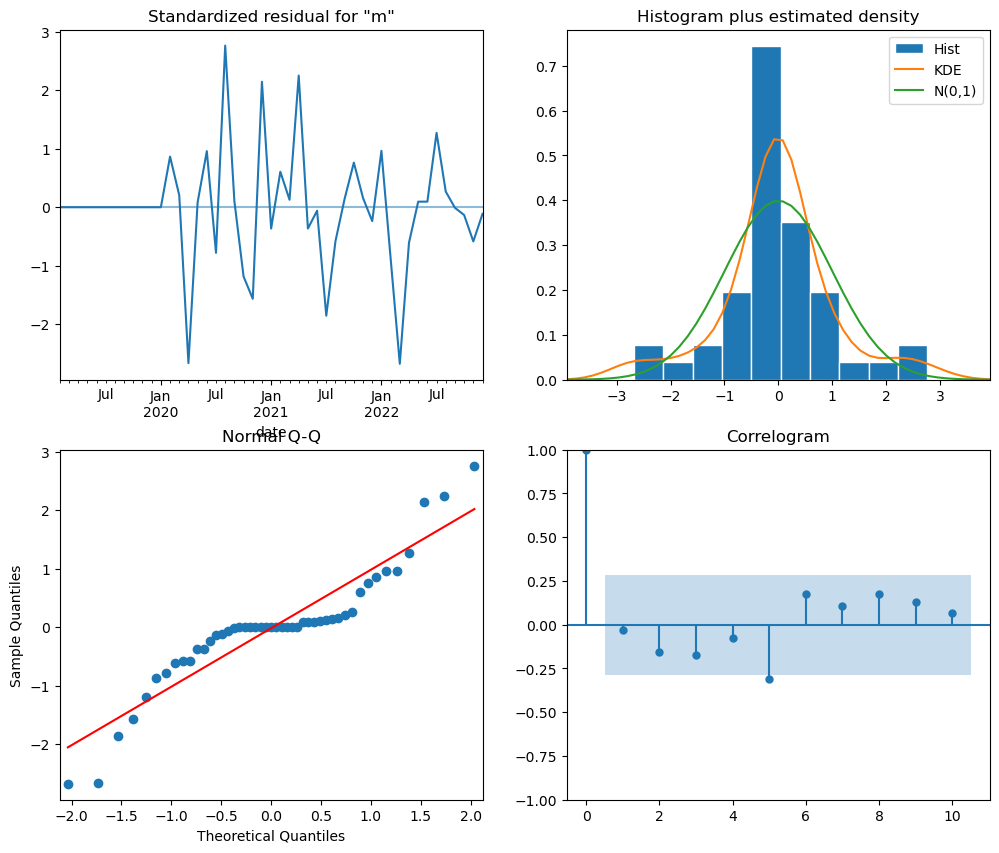

In [49]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

In [50]:
# прогноз

pred = model_fit.get_prediction(start=split_date.strftime('%Y-%m-%d'), end='2025-03-01', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean

res = transformer_2.inverse_transform(vol_diff_pred)
res = transformer_1.inverse_transform(res)
res

2023-01-01    8.135781e+05
2023-02-01    9.811311e+05
2023-03-01    8.306940e+05
2023-04-01    8.241485e+05
2023-05-01    6.896086e+05
2023-06-01    9.639314e+05
2023-07-01    9.468746e+05
2023-08-01    9.805121e+05
2023-09-01    1.112603e+06
2023-10-01    1.132446e+06
2023-11-01    9.867939e+05
2023-12-01    1.390713e+06
2024-01-01    8.352821e+05
2024-02-01    1.008163e+06
2024-03-01    8.543089e+05
2024-04-01    8.482997e+05
2024-05-01    7.104221e+05
2024-06-01    9.938706e+05
2024-07-01    9.771161e+05
2024-08-01    1.012690e+06
2024-09-01    1.150095e+06
2024-10-01    1.171605e+06
2024-11-01    1.021786e+06
2024-12-01    1.441256e+06
2025-01-01    8.663765e+05
2025-02-01    1.046585e+06
2025-03-01    8.876226e+05
Freq: MS, Name: predicted_mean, dtype: float64

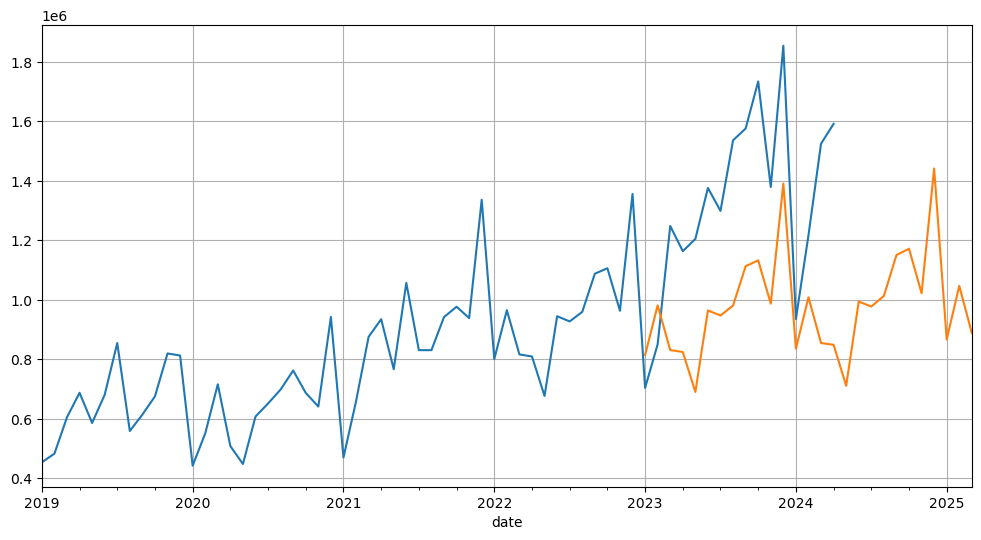

In [51]:
my_df = df.copy()
my_df = my_df[['date','msp_loans_volume']]
my_df['msp_loans_volume'] = my_df['msp_loans_volume'].astype(float)

my_df.set_index(keys='date', drop=True, inplace=True)
my_df = my_df.squeeze(axis=1)

plt.figure(figsize=(12, 6))
my_df.plot()
res.plot()
plt.grid(True)
plt.show()

In [52]:
test_pred = res[0:test_size]
mape(tst_ser.values, test_pred.values) 
# Все резко ухудшилось(((

29.108535426043368

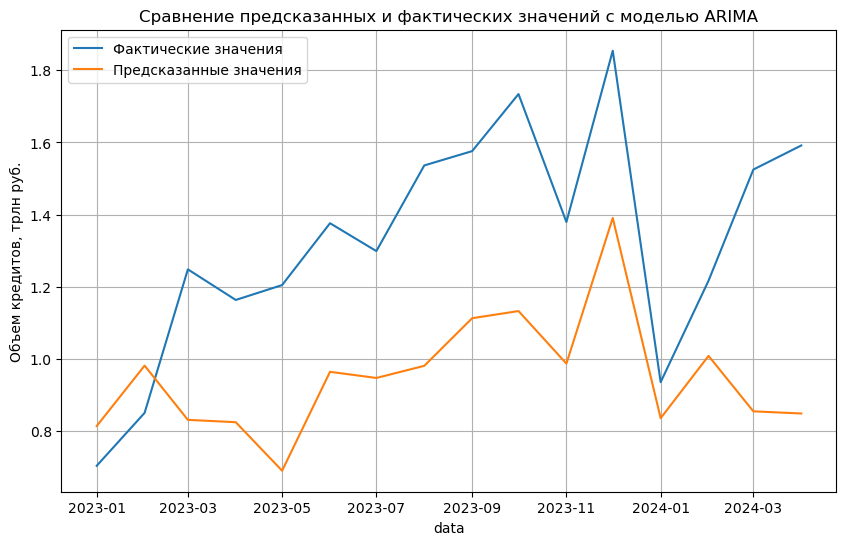

In [53]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()

Вариант 3 (split_date после 2023-01-01)

In [175]:
split_date = '2023-05'
n = df.index[df['date'] == split_date]
train_size = n[0]
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

train_size =  52
test_size =  12


Если в коде выше установить split_date в промежутке [ 2023-01; 2023-03 ], то можем заметить сильное ухудшение качесва модели.

In [176]:
# разделение данных на тестовые и тренировочные

train = df[df['date']<split_date]
test = df[df['date']>=split_date]

In [177]:
# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

In [178]:
# Мы уже знаем, что исходные данные не стационарны, поэтому сразу применим к ним операции трансформации

transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
print(adfuller(trn_transform))# Данные не стационарны

transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

print(adfuller(trn_transform))# Данные стационарны!

(0.14692045805900175, 0.9691223680056467, 11, 40, {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}, -6.424397131107298)
(-5.621495690243114, 1.1423796922798034e-06, 4, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, -9.884706741251392)


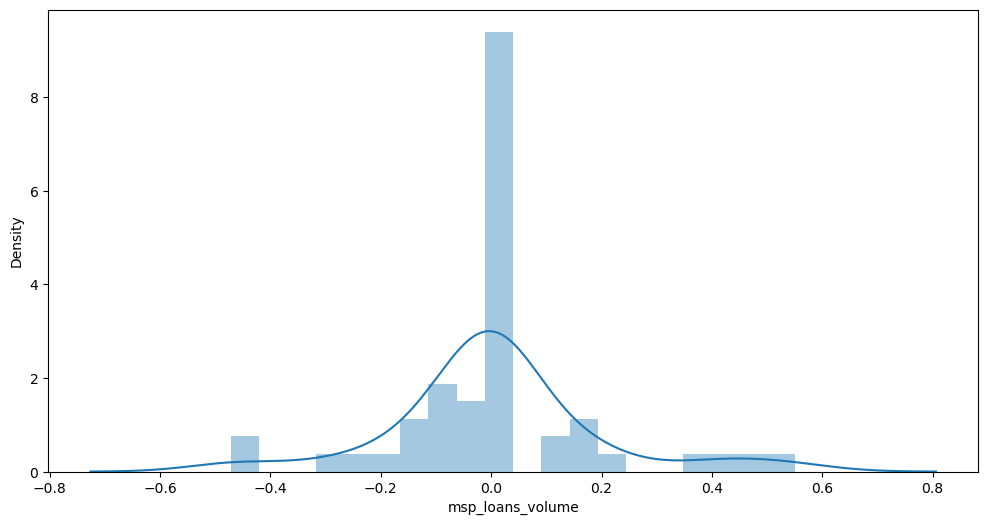

In [179]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(trn_transform)
plt.show()

In [180]:
# обучение модели

model = ARIMA(trn_transform, order=(1,0,1))
model_fit = model.fit()
model_fit.aic

-28.41684021955119

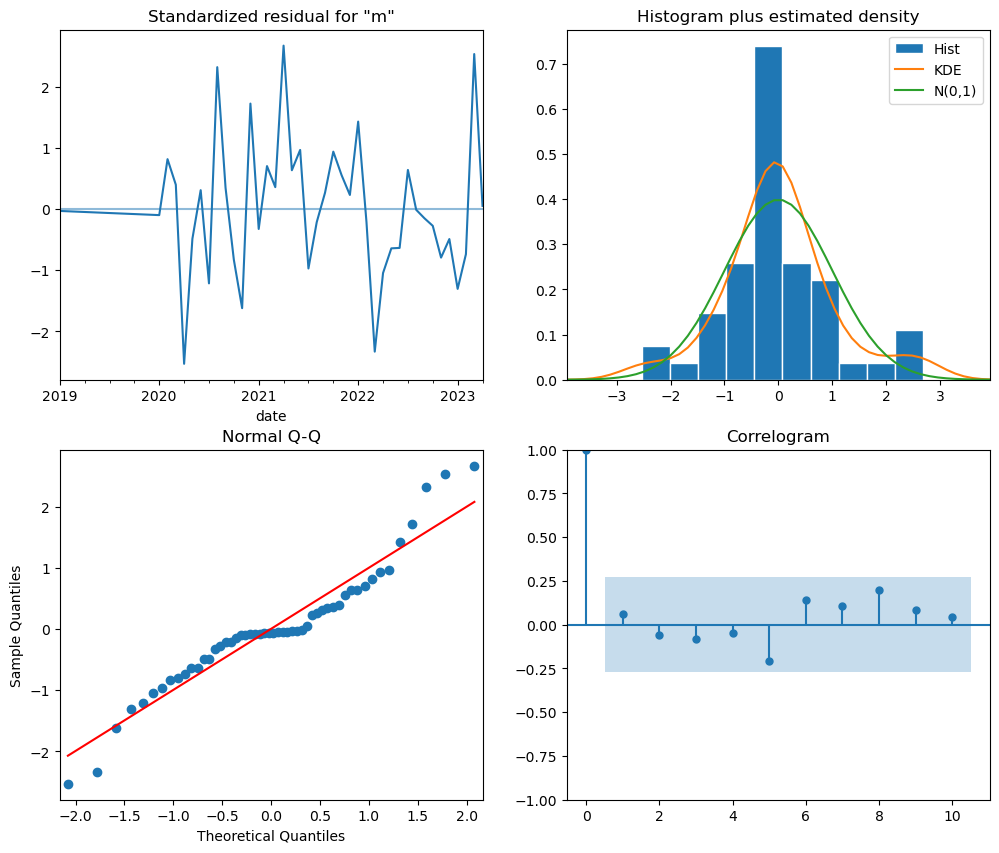

In [181]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

In [182]:
# прогноз

pred = model_fit.get_prediction(start=split_date, end='2028-03-01', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean

res = transformer_2.inverse_transform(vol_diff_pred)
res = transformer_1.inverse_transform(res)
res

2023-05-01    9.288835e+05
2023-06-01    1.262843e+06
2023-07-01    1.220993e+06
2023-08-01    1.253826e+06
2023-09-01    1.417508e+06
2023-10-01    1.441723e+06
2023-11-01    1.257686e+06
2023-12-01    1.776512e+06
2024-01-01    9.251325e+05
2024-02-01    1.122996e+06
2024-03-01    1.656461e+06
2024-04-01    1.551178e+06
2024-05-01    1.244745e+06
2024-06-01    1.700668e+06
2024-07-01    1.652547e+06
2024-08-01    1.705534e+06
2024-09-01    1.937932e+06
2024-10-01    1.981025e+06
2024-11-01    1.736913e+06
2024-12-01    2.465890e+06
2025-01-01    1.290656e+06
2025-02-01    1.574658e+06
2025-03-01    2.334488e+06
2025-04-01    2.197224e+06
2025-05-01    1.772130e+06
2025-06-01    2.433534e+06
2025-07-01    2.376700e+06
2025-08-01    2.465381e+06
2025-09-01    2.815561e+06
2025-10-01    2.892805e+06
2025-11-01    2.549237e+06
2025-12-01    3.637548e+06
2026-01-01    1.913588e+06
2026-02-01    2.346535e+06
2026-03-01    3.496514e+06
2026-04-01    3.307661e+06
2026-05-01    2.681298e+06
2

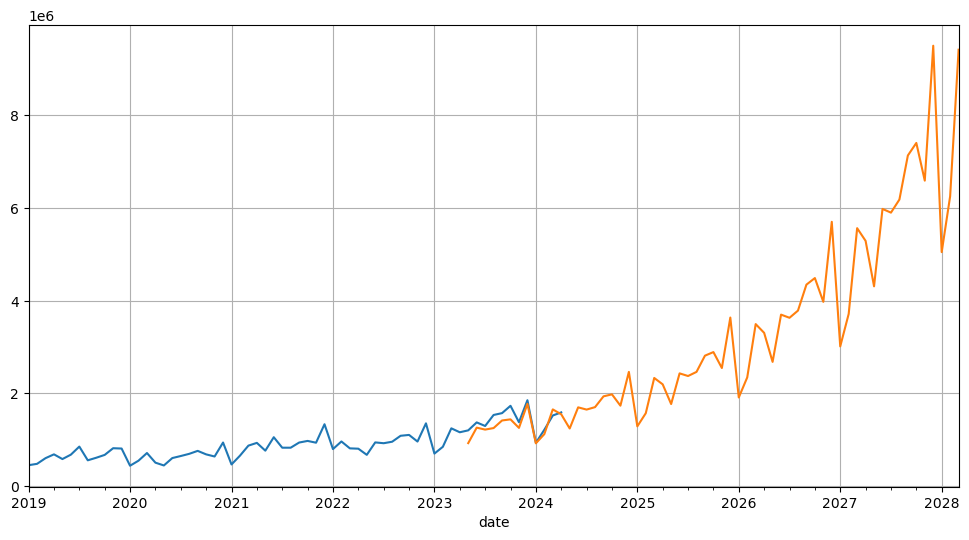

In [183]:
my_df = df.copy()
my_df = my_df[['date','msp_loans_volume']]
my_df['msp_loans_volume'] = my_df['msp_loans_volume'].astype(float)

my_df.set_index(keys='date', drop=True, inplace=True)
my_df = my_df.squeeze(axis=1)

plt.figure(figsize=(12, 6))
my_df.plot()
res.plot()
plt.grid(True)
plt.show()

In [95]:
test_pred = res[0:test_size]
mape(tst_ser.values, test_pred.values)

9.615089087094306

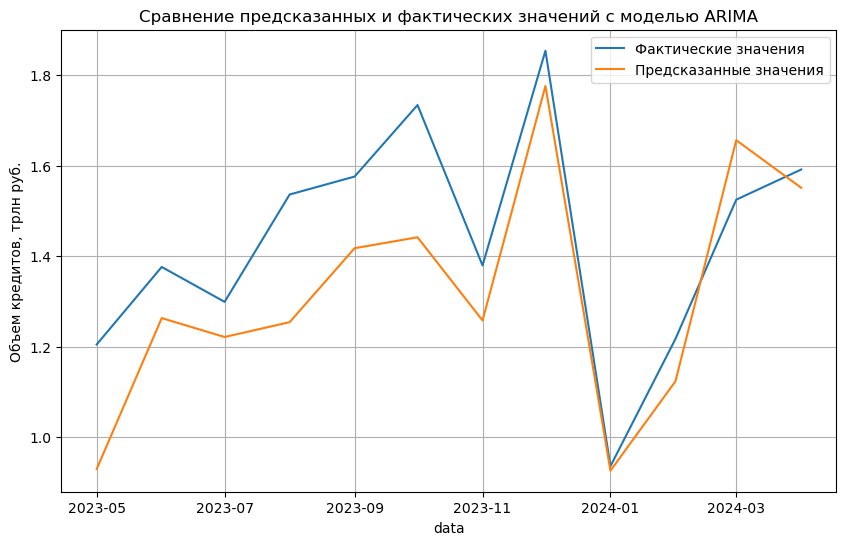

In [96]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()

# SARIMAX

In [306]:
split_date = '2023-05'
n = df.index[df['date'] == split_date]
train_size = n[0]
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

# разделение данных на тестовые и тренировочные

train = df[df['date']<split_date]
test = df[df['date']>=split_date]

# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

df_ser = df.copy()
df_ser.set_index(keys='date', drop=True, inplace=True)
df_ser = df_ser.squeeze(axis=1)
# Мы уже знаем, что исходные данные не стационарны, поэтому сразу применим к ним операции трансформации

transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
print(adfuller(trn_transform))# Данные не стационарны

transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

print(adfuller(trn_transform))# Данные стационарны!

train_size =  52
test_size =  12
(0.14692045805900175, 0.9691223680056467, 11, 40, {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}, -6.424397131107298)
(-5.621495690243114, 1.1423796922798034e-06, 4, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, -9.884706741251392)


In [307]:
# обучение модели
# используем сырые данные
# Параметры модели позоваляют привести данные в стационарный вид и обратно
model = SARIMAX(trn_ser, order=(1,1,1), seasonal_order=(1,1,1,12), trend='ct' , measurement_error=True, enforce_stationarity=True, enforce_invertibility=True ) 
model_fit = model.fit() 
model_fit.aic


1057.3793635634709

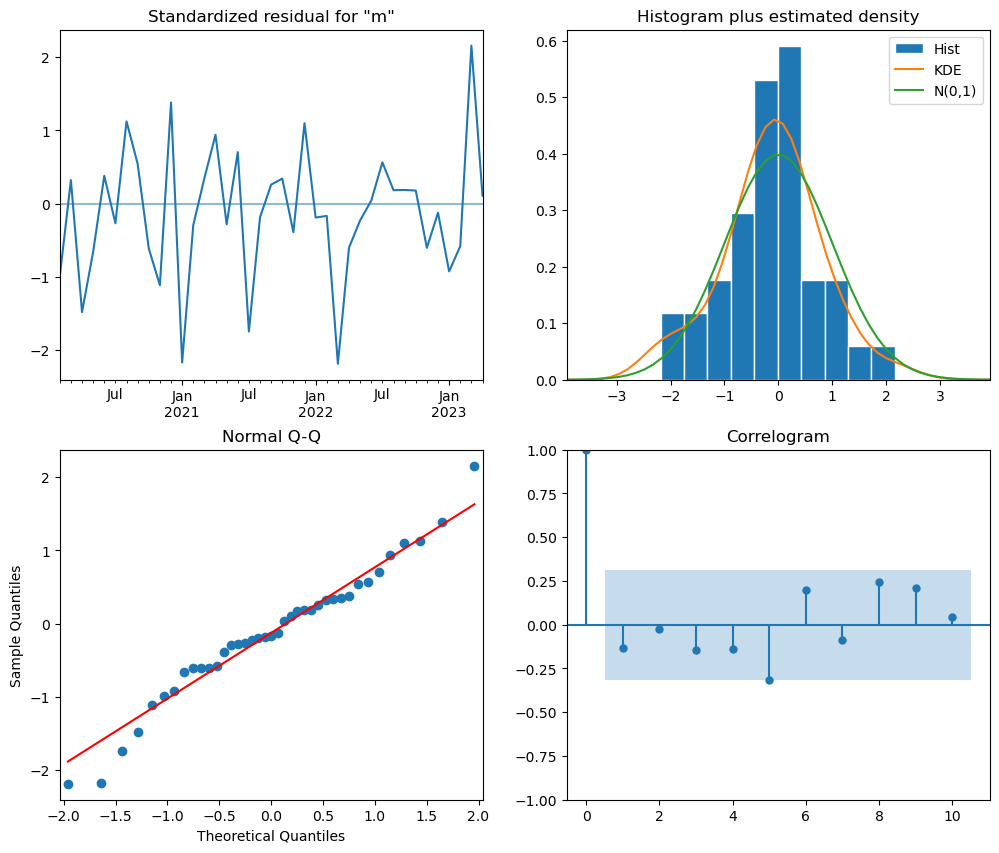

In [308]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

In [309]:
# прогноз

pred = model_fit.get_prediction(start=split_date, end='2026-03-01', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean
vol_diff_pred
# res = transformer_2.inverse_transform(vol_diff_pred)
# res = transformer_1.inverse_transform(res)
# res

2023-05-01    1.038629e+06
2023-06-01    1.326223e+06
2023-07-01    1.230858e+06
2023-08-01    1.259380e+06
2023-09-01    1.391760e+06
2023-10-01    1.428776e+06
2023-11-01    1.338544e+06
2023-12-01    1.744939e+06
2024-01-01    1.148829e+06
2024-02-01    1.312077e+06
2024-03-01    1.492811e+06
2024-04-01    1.448014e+06
2024-05-01    1.330400e+06
2024-06-01    1.619299e+06
2024-07-01    1.568268e+06
2024-08-01    1.608166e+06
2024-09-01    1.748438e+06
2024-10-01    1.786862e+06
2024-11-01    1.682801e+06
2024-12-01    2.092701e+06
2025-01-01    1.481045e+06
2025-02-01    1.646289e+06
2025-03-01    1.932397e+06
2025-04-01    1.878990e+06
2025-05-01    1.767335e+06
2025-06-01    2.064621e+06
2025-07-01    2.002856e+06
2025-08-01    2.046521e+06
2025-09-01    2.192019e+06
2025-10-01    2.238456e+06
2025-11-01    2.149067e+06
2025-12-01    2.565887e+06
2026-01-01    1.969499e+06
2026-02-01    2.142166e+06
2026-03-01    2.389873e+06
Freq: MS, Name: predicted_mean, dtype: float64

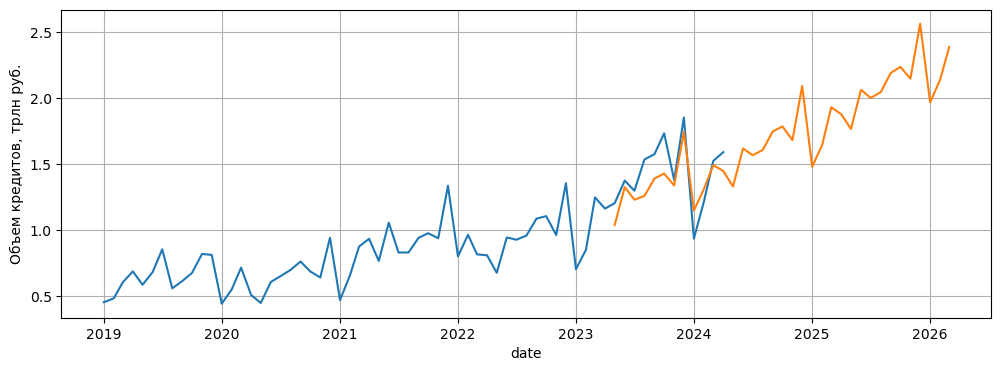

In [310]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.plot(vol_diff_pred / 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

In [311]:
test_pred = vol_diff_pred[0:test_size]
mape(tst_ser.values, test_pred.values)

10.05308092802134

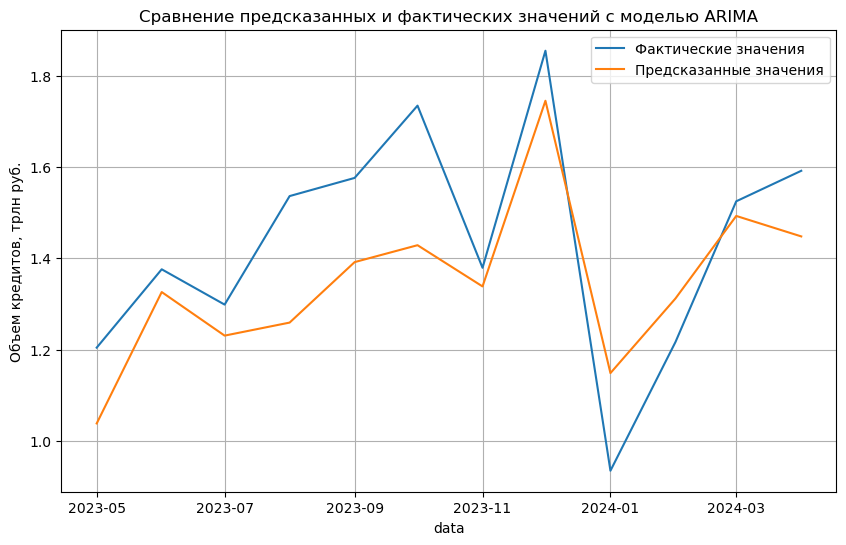

In [312]:
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()

Обучение на всех данных

In [313]:
model = SARIMAX(df_ser, order=(1,1,0), seasonal_order=(0,1,1,12), trend='ct' , measurement_error=True, enforce_stationarity=True, enforce_invertibility=True ) 
model_fit = model.fit() 
model_fit.aic

1372.828789085588

In [314]:
pred = model_fit.get_prediction(start='2024-05-01', end='2026-03-01', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean
vol_diff_pred

2024-05-01    1.566564e+06
2024-06-01    1.793434e+06
2024-07-01    1.738270e+06
2024-08-01    1.935152e+06
2024-09-01    2.016300e+06
2024-10-01    2.154582e+06
2024-11-01    1.888217e+06
2024-12-01    2.356818e+06
2025-01-01    1.545524e+06
2025-02-01    1.811188e+06
2025-03-01    2.130043e+06
2025-04-01    2.181824e+06
2025-05-01    2.183007e+06
2025-06-01    2.423241e+06
2025-07-01    2.385817e+06
2025-08-01    2.599292e+06
2025-09-01    2.697648e+06
2025-10-01    2.853193e+06
2025-11-01    2.604323e+06
2025-12-01    3.090595e+06
2026-01-01    2.297165e+06
2026-02-01    2.580881e+06
2026-03-01    2.917979e+06
Freq: MS, Name: predicted_mean, dtype: float64

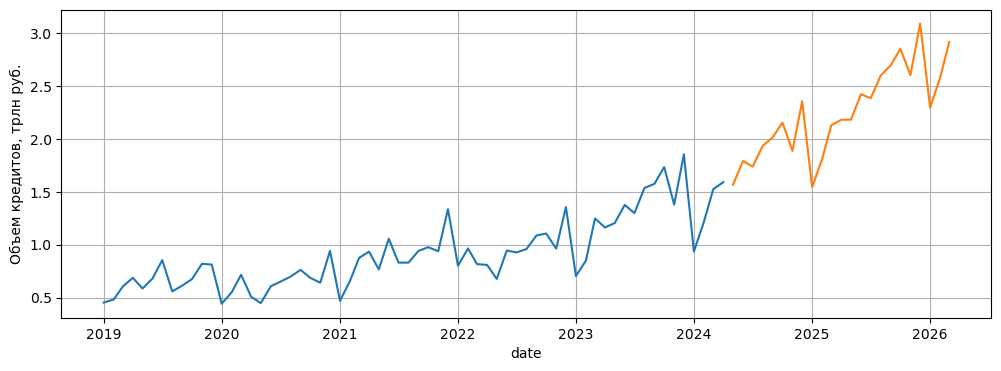

In [315]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.plot(vol_diff_pred / 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

Подбор параметров

In [363]:
# импортируем функцию для автоматического подбора параметров модели ARIMA
from pmdarima import auto_arima


# настроим поиск параметров на обучающей выборке
parameter_search = auto_arima(trn_ser, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True, 
#                          trend='ct', 
                              with_intercept=True)           

# выведем результат
print(parameter_search.summary())

type(parameter_search)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1072.087, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1087.232, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1074.474, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1076.173, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1097.844, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1083.780, Time=0.05 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1065.928, Time=0.41 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1065.500, Time=0.23 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1066.203, Time=0.46 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=1067.903, Time=0.80 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1075.686, Time=0.10 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=1067.002, Time=0.34 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=1066.837, Time=0.26 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1077.959, Time=0.07 sec
 ARIMA(0,0,2)(1,1,0

pmdarima.arima.arima.ARIMA

In [364]:
s_ord = parameter_search.seasonal_order
pdq = parameter_search.order

In [365]:
model = SARIMAX(trn_ser, order=pdq, seasonal_order=s_ord, trend='ct' , measurement_error=True, enforce_stationarity=True, enforce_invertibility=True ) 
model_fit = model.fit() 
model_fit.aic

1074.1291385252925

In [366]:
pred = model_fit.get_prediction(start=split_date, end='2026-03-01', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean
vol_diff_pred

2023-05-01    9.962968e+05
2023-06-01    1.273683e+06
2023-07-01    1.182107e+06
2023-08-01    1.206070e+06
2023-09-01    1.332281e+06
2023-10-01    1.361249e+06
2023-11-01    1.261424e+06
2023-12-01    1.661081e+06
2024-01-01    1.056384e+06
2024-02-01    1.214395e+06
2024-03-01    1.416241e+06
2024-04-01    1.364866e+06
2024-05-01    1.215469e+06
2024-06-01    1.494397e+06
2024-07-01    1.434988e+06
2024-08-01    1.466869e+06
2024-09-01    1.598760e+06
2024-10-01    1.628778e+06
2024-11-01    1.517971e+06
2024-12-01    1.920077e+06
2025-01-01    1.302738e+06
2025-02-01    1.461527e+06
2025-03-01    1.740479e+06
2025-04-01    1.681694e+06
2025-05-01    1.530768e+06
2025-06-01    1.814049e+06
2025-07-01    1.747727e+06
2025-08-01    1.781615e+06
2025-09-01    1.916337e+06
2025-10-01    1.950889e+06
2025-11-01    1.849042e+06
2025-12-01    2.255167e+06
2026-01-01    1.647399e+06
2026-02-01    1.810822e+06
2026-03-01    2.066328e+06
Freq: MS, Name: predicted_mean, dtype: float64

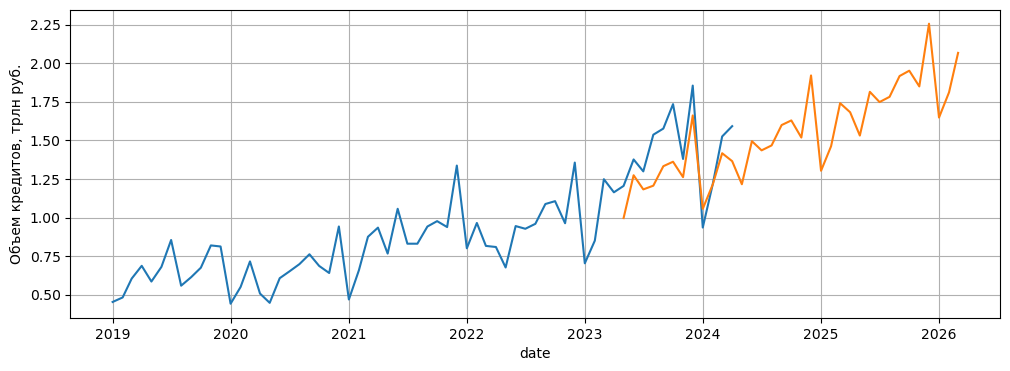

In [367]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.plot(vol_diff_pred / 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

In [368]:
test_pred = vol_diff_pred[0:test_size]
mape(tst_ser.values, test_pred.values)

12.140846662756356